# 5.11 Final Project: Sentiment Analysis on COVID-19 Vaccine with Tweets

- Arshiya Ansari - aa9yk
- Congxin (David) Xu - cx2rx
- Pengwei (Tiger) Hu - ph3bz
- Kip McCharen - cam7cu

In [1]:
import os
import pandas as pd

# Getting the current directory of interest
thisdir = '/project/ds5559/twitter_sentiment_analysis_group/'

dfALL = pd.DataFrame()

# r=root, d=directories, f = files
for r, d, f in os.walk(thisdir):
    for file in f:
        if file.endswith(".csv"):
            filedir = os.path.join(r, file)
            print(filedir)
            tmpdf = pd.read_csv(filedir, index_col = 0, lineterminator='\n')
            dfALL = pd.concat([dfALL, tmpdf])

/project/ds5559/twitter_sentiment_analysis_group/hashtag_output_210318_0309.csv
/project/ds5559/twitter_sentiment_analysis_group/hashtag_output_210320_1148.csv
/project/ds5559/twitter_sentiment_analysis_group/hashtag_output_210321_1119.csv
/project/ds5559/twitter_sentiment_analysis_group/hashtag_output_210318_1359.csv
/project/ds5559/twitter_sentiment_analysis_group/hashtag_output_early_attempt.csv
/project/ds5559/twitter_sentiment_analysis_group/hashtag_output_210319_1252.csv
/project/ds5559/twitter_sentiment_analysis_group/hashtag_output_210319_2253.csv
/project/ds5559/twitter_sentiment_analysis_group/hashtag_output_210320_0902.csv
/project/ds5559/twitter_sentiment_analysis_group/hashtag_output_210317_1203.csv
/project/ds5559/twitter_sentiment_analysis_group/hashtag_output_210321_0531.csv
/project/ds5559/twitter_sentiment_analysis_group/hashtag_output_210321_0055.csv
/project/ds5559/twitter_sentiment_analysis_group/hashtag_output_210321_1044.csv
/project/ds5559/twitter_sentiment_anal

## Data Frame Dimension
- Number of records
- Number of columns

In [2]:
print(f'Our data frame contains {dfALL.shape[0]} rows and {dfALL.shape[1]} columns')

Our data frame contains 1244091 rows and 20 columns


In [3]:
# Preview the data
data = dfALL.copy()
data.head(2)

,scraped_hashtag,scraped_order,created_at,id_str,text,truncated,in_reply_to_screen_name,retweet_count,favorite_count,lang,screen_name,user_name,user_description,user_verified,user_followers_count,hashtags,symbols,og_tweet_by,og_tweet_truncated\r,og_tweet_truncated
0,#vaccine,0,Thu Mar 18 01:05:26 +0000 2021,1372353417507565569,BIG NEWS from @GovSisolak: #COVID19Vaccine eli...,True,NaN,0,0,en,atdleft,Andrew Davey,"Muckraker, troublemaker, & no-BS-taker. I'm a ...",False,2034,['COVID19Vaccine'],[],NaN,\r,NaN
1,#vaccine,0,Thu Mar 18 01:05:15 +0000 2021,1372353373123407879,@TerryBrady2097 This #Health #COVID19 #Vaccine...,True,TerryBrady2097,0,0,en,pully8,rose lane,NaN,False,513,"['Health', 'COVID19', 'Vaccine', 'agedcare']",[],NaN,\r,NaN


In [4]:
data.columns

Index(['scraped_hashtag', 'scraped_order', 'created_at', 'id_str', 'text',
       'truncated', 'in_reply_to_screen_name', 'retweet_count',
       'favorite_count', 'lang', 'screen_name', 'user_name',
       'user_description', 'user_verified', 'user_followers_count', 'hashtags',
       'symbols', 'og_tweet_by', 'og_tweet_truncated\r', 'og_tweet_truncated'],
      dtype='object')

## Response Variable

What we are planning to do is to perform a sentiment analysis, which is an unsupervised learning process. We would like to extract the sentiments of the general public towards the COVID-19 vaccine based on the relevants tweets. Therefore, we do not have our response variable at this moment, but we will perform an ad-hoc analysis on our response variable after extracting the sentiments.

## Predictor Variables

### Hashtags and Languages

In [5]:
data.lang.describe()

count     1244091
unique          1
top            en
freq      1244091
Name: lang, dtype: object

In [6]:
len(data.loc[data.lang != 'en'])

0

Here we can see that all of our scraped tweets are based on English.

In [7]:
data.hashtags.describe()

count     1244091
unique      22869
top            []
freq       766029
Name: hashtags, dtype: object

**There are 766029 tweets without hashtags.**

In [8]:
data.hashtags = data.hashtags.str.replace('[', '') \
    .str.replace(']', '') \
    .str.replace("'", "") \
    .str.replace(" ", "") \
    .str.split(',')

In [9]:
data.hashtags.head()

0                        [COVID19Vaccine]
1    [Health, COVID19, Vaccine, agedcare]
2                      [Florida, COVID19]
3                                      []
4                         [kissmeimirish]
Name: hashtags, dtype: object

In [10]:
hashtages = [hashtages for sublist in list(data.hashtags) for hashtages in sublist]
hashtages[:10]

['COVID19Vaccine',
 'Health',
 'COVID19',
 'Vaccine',
 'agedcare',
 'Florida',
 'COVID19',
 '',
 'kissmeimirish',
 'COVID19Vaccine']

In [11]:
from collections import Counter
hashtag_num = Counter(hashtages)

In [12]:
hashtag_num = pd.DataFrame.from_dict(hashtag_num, orient='index').reset_index()

In [13]:
hashtag_num.columns = ['hashtags', 'count']

In [14]:
hashtag_num.sort_values('count', ascending = False).head(10)

,hashtags,count
6,,766029
2,COVID19,99345
41,AstraZeneca,35886
37,CovidVaccine,33535
350,SputnikV,25405
9,vaccine,20558
0,COVID19Vaccine,19378
559,GetVaccinated,17866
325,CoronaVaccine,14743
676,astrazenecavaccine,14685


**Here we have the 10 most frequent hashtages.**

### Text and User Description

For the purpose of analysis, we are considering user descriptions as a part of a worldview which helps encapsulate opinions towards vaccines, so we have combined user descriptions with tweet content. 

In [15]:
tud = data[["text", "user_description"]].drop_duplicates()
tud['fulltext'] = tud.text + " " + tud.user_description.fillna("")
tud = tud.dropna().copy()
tud = tud.drop(columns=["text", "user_description"])
tud.head()

,fulltext
0,BIG NEWS from @GovSisolak: #COVID19Vaccine eli...
2,"RT @GeoRebekah: Attention #Florida!\n\nIf you,..."
3,RT @JulianHillMP: Scotty promised Australians ...
4,Don’t #kissmeimirish ! Stand back at the end o...
5,BIG NEWS from @GovSisolak: #COVID19Vaccine eli...


In [16]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer().fit(tud.fulltext)
bag_of_words = vec.transform(tud.fulltext)
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
# vec = vectorizer.fit_transform(tud.fulltext)
# feats = vectorizer.get_feature_names()
# print(len(feats))

In [17]:
import numpy as np 

wf_df = pd.DataFrame(words_freq[:100], columns=["word", "freq"])
wf_df["log_freq"] = np.log(wf_df.freq)
wf_df.head(25)

,word,freq,log_freq
0,the,363216,12.802753
1,rt,229471,12.343532
2,of,218389,12.294033
3,to,212838,12.268287
4,and,203025,12.221084
5,co,167271,12.027371
6,https,166675,12.023801
7,in,148589,11.908939
8,is,120225,11.697120
9,vaccine,102349,11.536144


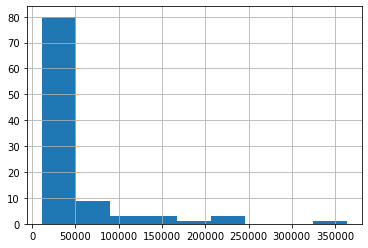

In [18]:
hist = wf_df.freq.hist(bins=9)

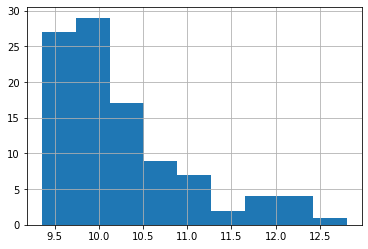

In [19]:
hist = wf_df.log_freq.hist(bins=9)

In [20]:
bag_of_words.shape

(336783, 427928)

**There are 427,928 unique words in this corpus of tweets and twitter user bios.** 

In addition, they appear to roughly follow Zipf's law of frequent proportional representation with a log-like decreasing curve of the log-frequency of words.

The most frequent words, as expected, are not particularly interesting, and mostly represent stop words, or at least the COVID Twitter equivalent. 

## User Follower Counts

In [21]:
dfALL[["user_followers_count"]].describe()

,user_followers_count
count,1.244091e+06
mean,2.875744e+04
std,5.136353e+05
min,0.000000e+00
25%,1.360000e+02
50%,5.300000e+02
75%,2.063000e+03
max,6.115498e+07


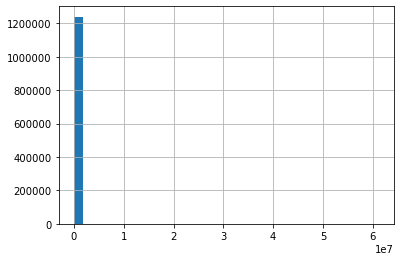

In [22]:
hist = dfALL.user_followers_count.hist(bins = 35)

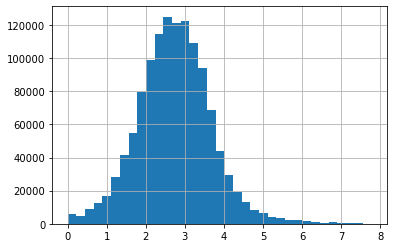

In [23]:
hist = np.log10(dfALL.user_followers_count + 1).hist(bins = 35)

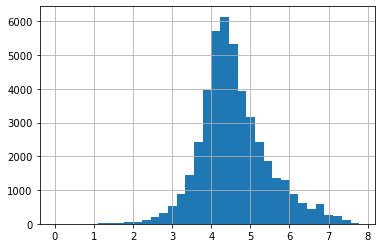

In [24]:
hist = np.log10(dfALL.user_followers_count.drop_duplicates() + 1).hist(bins=35)

The number of user followers is highly skewed upwards, with such range and variation that the standard deviation is higher than the mean. Indeed it's impossible to see the histogram distribution in raw values. By taking the natural log, we can see that user follower counts follow a standard Gaussian distribution. However, when we remove duplicates (looking at the distribution by unique user), there is an extremely large skew downwards. It seems that popular Twitter users are overly represented in our dataset. 

### Retweet Counts

In [25]:
data[["retweet_count"]].describe()

,retweet_count
count,1.244091e+06
mean,2.741226e+02
std,1.200028e+03
min,0.000000e+00
25%,1.000000e+00
50%,1.200000e+01
75%,1.240000e+02
max,1.366980e+05


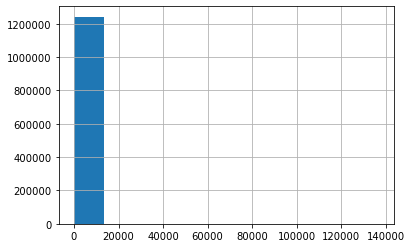

In [26]:
hist = data.retweet_count.hist(bins=10)

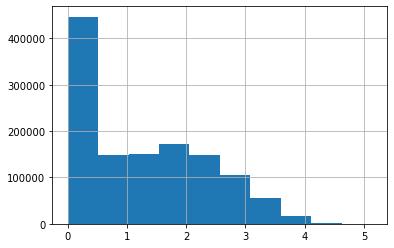

In [27]:
hist = np.log10(data.retweet_count+1).hist(bins=10)

The highly skewed distribution entails that some tweets (a smaller count of them) have an extremely high count of retweets. These would be 'viral' tweets, or tweets from government officials, celebrities, that get a lot of traction. Retweets allow people to share information shared in other tweets to their followers and timeline, and during the pandemic, it was a big tool Twitter users used to spread information about COVID-19 and the vaccine.

### Retweets Grouped by Hashtags 

In [28]:
rts = data[['scraped_hashtag','retweet_count']] \
    .groupby('scraped_hashtag') \
    .mean() \
    .sort_values('retweet_count', ascending = False)

In [29]:
cleaned_rts = rts.loc[~(rts==0).all(axis=1)]
cleaned_rts = cleaned_rts.reset_index()
cleaned_rts = cleaned_rts[:10]

print("Top ten scraped hashtags by retweet count")
cleaned_rts

Top ten scraped hashtags by retweet count


,scraped_hashtag,retweet_count
0,gavi,1577.018062
1,endthelockdown,1351.108117
2,covax,1334.543997
3,covid19 biontech,1079.868953
4,vaccine,915.345025
5,vaccination,713.256219
6,sputnikv,673.772467
7,vaccinate,621.014776
8,coronavirus biontech,613.337683
9,#sputnikv,565.373900


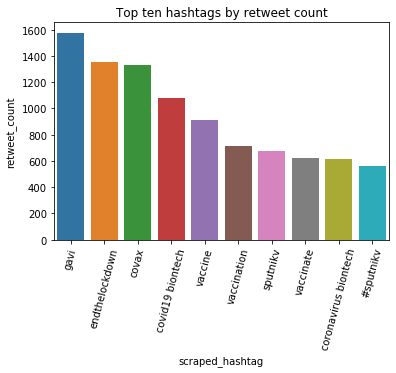

In [30]:
import seaborn as sns
import matplotlib as plt

# sns.set_theme(style="whitegrid")
ax = sns.barplot(x="scraped_hashtag", y="retweet_count", data=cleaned_rts)
ax.set_title("Top ten hashtags by retweet count")
for item in ax.get_xticklabels():
    item.set_rotation(75)

### Favorite Counts 

In [31]:
data[["favorite_count"]].describe()

,favorite_count
count,1.244091e+06
mean,2.349503e+00
std,6.712127e+01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,2.632100e+04


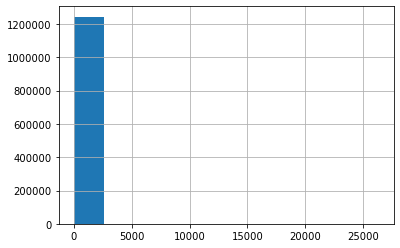

In [32]:
hist = data.favorite_count.hist(bins=10)

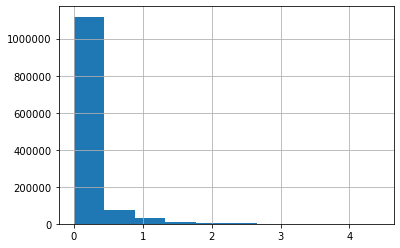

In [33]:
hist = np.log10(data.favorite_count+1).hist(bins=10)

It is surprising to see that the number of favorites per tweet is heavily skewed towards the lower end with a smaller range for the distrbution than the retweet count, because it could be hypothesized that the retweet and favorite distributions should look very similar due to them both being aspects of user interaction with a tweet. The only explanation of this difference could be that during the pandemic, users are more inclined to press retweet and share health information with their timeline, rather than just favorite and interact with tweets that way. 

### Favorite Counts Grouped by Hashtags 

In [34]:
faves = data[['scraped_hashtag','favorite_count']] \
    .groupby('scraped_hashtag') \
    .mean() \
    .sort_values('favorite_count', ascending = False)

In [35]:
cleaned_faves = faves.loc[~(faves==0).all(axis=1)]
cleaned_faves = cleaned_faves.reset_index()
cleaned_faves = cleaned_faves[:10]

print("Top ten scraped hashtags by favorite count")
cleaned_faves

Top ten scraped hashtags by favorite count


,scraped_hashtag,favorite_count
0,vaccinessavelives,7.719791
1,pfizercovidvaccine,4.489242
2,modernavaccine,4.484827
3,#pfizercovidvaccine,4.429213
4,covidvaccine pfizer,4.382253
5,#modernavaccine,4.143973
6,#vaccinessavelives,4.133586
7,#covid_19 #pfizer,4.007884
8,#plandemic,3.950668
9,#thisisourshot,3.680466


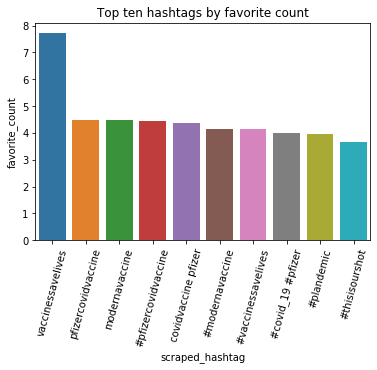

In [36]:
# sns.set_theme(style="whitegrid")
ax2 = sns.barplot(x="scraped_hashtag", y="favorite_count", data=cleaned_faves)
ax2.set_title("Top ten hashtags by favorite count")
for item in ax2.get_xticklabels():
    item.set_rotation(75)

### Scraped Hashtag

We collected our relevant tweets by searching through these keywords through Twitter API

#### Count Table

In [37]:
data[['scraped_hashtag','text']] \
    .groupby('scraped_hashtag') \
    .count() \
    .sort_values('text', ascending = False)

,text
scraped_hashtag,
vaccinessavelives,41594
coronavirus astrazeneca,22700
gavi,22700
covidvaccine,22700
covid_19 astrazeneca,22700
...,...
#iwillgetvaccinated,16
#corona #biontech,16
#modernacovidvaccine,5


#### Frequency Table

In [38]:
data[['scraped_hashtag','text']] \
    .groupby('scraped_hashtag') \
    .count() \
    .sort_values('text', ascending = False)  \
    .head(10) / len(data) * 100

,text
scraped_hashtag,
vaccinessavelives,3.343325
coronavirus astrazeneca,1.824625
gavi,1.824625
covidvaccine,1.824625
covid_19 astrazeneca,1.824625
rna,1.824625
sputnikv,1.824625
covid_19 moderna,1.776397
coronavirus moderna,1.776397


We can see that majority of the tweets we collected are associated with the **vaccinessavelives**, **coronavirus astrazeneca**, **gavi**, **covidvaccine**, etc.

### Creation Date

In [39]:
x = pd.to_datetime(data.created_at)
x.head()

0   2021-03-18 01:05:26+00:00
1   2021-03-18 01:05:15+00:00
2   2021-03-18 01:04:30+00:00
3   2021-03-18 01:04:29+00:00
4   2021-03-18 01:04:15+00:00
Name: created_at, dtype: datetime64[ns, UTC]

In [40]:
x.describe()

count                       1244091
unique                       266231
top       2021-03-17 14:00:04+00:00
freq                            120
first     2021-03-08 20:18:51+00:00
last      2021-03-21 14:32:46+00:00
Name: created_at, dtype: object

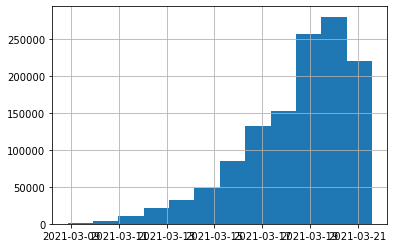

In [41]:
x.hist(bins = 12);

Majority of our tweets are collected over the weekend and we set our beginning date to be March 1. We can see from this histogram above that most of the tweets are created over the last 5 days. 